In [1]:
import torch
torch.__version__

'2.5.0+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import os
from tqdm import tqdm
from sklearn.metrics import f1_score
from torchvision.models import mobilenet_v3_large
import random
from torch.utils.data import WeightedRandomSampler
import math
from mpl_toolkits.mplot3d import Axes3D

C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
# Set seed for reproducibility
SEED = 123
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Load Data

In [5]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(10),     # Randomly rotate by 10 degrees
    transforms.RandomResizedCrop(
        size=IMG_SIZE,  # Output size
        scale=(0.8, 1.0)  # Range of the random crop size relative to the input size
    ),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
]) 

# Create transform pipeline manually
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

 
print(f"train transforms: {train_transforms}")
print(f"test transforms: {test_transforms}")

train transforms: Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
test transforms: Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [8]:
data = pd.read_csv('E://Kuliah//UPI//SEMESTER 8//dataset skripsi//fer2013_clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33325 entries, 0 to 33324
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pixels   33325 non-null  object
 1   emotion  33325 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 520.8+ KB


In [9]:
# Pertama, pisahkan data train (90%) dan validation (10%)
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=123)
data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=123)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26992
Validation set size: 3000
Test set size: 3333


In [10]:
train_dataset = FERDataset(data_train, transform=train_transforms)
val_dataset = FERDataset(data_val, transform=test_transforms)
test_dataset = FERDataset(data_test, transform=test_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

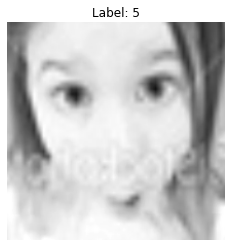

In [11]:
# Define the mean and std used for normalization
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Denormalize function
def denormalize(tensor, mean, std):
    # Clone the tensor to avoid modifying the original
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization: (t * s) + m
    return tensor

# Ambil satu contoh dari train_dataset
image, label = train_dataset[0]  # Index pertama dataset

# Denormalize the image
image = denormalize(image, mean, std)

# Jika transform menghasilkan tensor, konversi ke format numpy
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Clip the values to the valid range [0, 1]
image = image.clip(0, 1)

# Plot gambar
plt.imshow(image, cmap='gray')  # Gunakan cmap='gray' jika gambar grayscale
plt.title(f"Label: {label}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [12]:
image, label = train_dataset[0]
image.shape

torch.Size([3, 224, 224])

## Build Vision Transformer (ViT) Model

In [13]:
from torch import nn
import torch.nn.functional as F

In [14]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768
                ):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    def forward(self, x):
        image_resolution = x.shape[-1]
        
        x_patched = self.patcher(x) # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x_flattened = x_patched.flatten(2) # (n_samples, embed_dim, n_patches)
        x = x_flattened.transpose(1, 2) # (n_samples, n_patches, embed_dim)
        
        return x

In [15]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [16]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [17]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

In [29]:
class ViTMobileNet(nn.Module):
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0., # Dropout for attention projection
                 mlp_dropout:float=0., # Dropout for dense/MLP layers 
                 embedding_dropout:float=0., # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__()
         
        assert img_size % 32 == 0, f"Image size must be divisible by 32, image size: {img_size}"
        
        self.mobilenet = mobilenet_v3_large(pretrained=True).features
        
        self.projection = nn.Conv2d(in_channels=960, 
                                    out_channels=embedding_dim,
                                    kernel_size=1)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.num_patches = (img_size // 32) ** 2  # MobileNet reduces spatial size by 32x
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.norm = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        self.head = nn.Linear(in_features=embedding_dim, out_features=num_classes)
    
    def forward(self, pixel_values, labels=None):
        
        batch_size = pixel_values.shape[0]

        # Extract features using MobileNet
        features = self.mobilenet(pixel_values)  # Output shape: (batch_size, 1280, H', W')
        features = self.projection(features)  # Project to embedding_dim: (batch_size, embedding_dim, H', W')

        # Flatten the feature maps into a sequence of tokens
        features = features.flatten(2).transpose(1, 2)  # Shape: (batch_size, num_patches, embedding_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = torch.cat((class_token, features), dim=1)  # Shape: (batch_size, num_patches + 1, embedding_dim)

        x = x + self.position_embedding

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.norm(x)
        
        cls_token_final = x[:, 0]

        logits = self.head(cls_token_final)

        return logits

In [18]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.,
                 mlp_dropout:float=0.,
                 embedding_dropout:float=0.,
                 num_classes:int=1000):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, pixel_values, labels=None):
        batch_size = pixel_values.shape[0]

        x = self.patch_embedding(pixel_values) # (n_samples, num_patches, embed_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) # (n_samples, 1, embed_dim)

        x = torch.cat((class_token, x), dim=1) # (n_samples, 1 + n_patches, embed_dim)

        x = self.position_embedding + x # add position embed

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        logits = self.classifier(x[:, 0])
    
        return logits

# Testing

In [19]:
EPOCHS = 1000
LEARNING_RATE = 3e-5
NUM_CLASSES = 7
SEED = 123
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))

In [ ]:
# membuat dua arah acak untuk menggeser parameter model
def get_random_directions(model):
    directions = []
    for param in model.parameters():
        if param.requires_grad:
            d1 = torch.randn_like(param) # arah acak 1
            d2 = torch.randn_like(param) # arah acak 2
            d1 = d1 / (d1.norm() + 1e-10) # normalisasi agar magnitudenya = 1
            d2 = d2 / (d2.norm() + 1e-10)
            directions.append((d1, d2))
    return directions

In [ ]:
# Hitung nilai loss setiap kombinasi alpha dan beta
def compute_loss_surface(model, data_loader, directions, alphas, betas, device):
    loss_surface = np.zeros((len(alphas), len(betas)))

    # simpan parameter ori
    original_params = [p.detach().clone() for p in model.parameters() if p.requires_grad]

    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            # Modifikasi parameter ke arah alpha*dir1 + beta*dir2
            with torch.no_grad():
                idx = 0
                for p in model.parameters():
                    if p.requires_grad:
                        d1, d2 = directions[idx]
                        p.copy_(original_params[idx] + alpha * d1 + beta * d2)
                        idx += 1

            # Hitung loss
            model.eval()
            total_loss = 0.0
            total_samples = 0
            with torch.no_grad():
                pbar = tqdm(test_loader, desc="Testing")
                for batch_idx, (inputs, targets) in enumerate(pbar):
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                    outputs = model(inputs)
                    loss = F.cross_entropy(outputs, targets, reduction='sum')
                    total_loss += loss.item()
                    total_samples += targets.size(0)

            if total_samples == 0:
                loss_surface[i, j] = np.nan
            else:
                loss_surface[i, j] = total_loss / total_samples

    # Kembalikan parameter ke nilai awal
    with torch.no_grad():
        idx = 0
        for p in model.parameters():
            if p.requires_grad:
                p.copy_(original_params[idx])
                idx += 1

    return loss_surface

In [22]:
def plot_loss_surface(loss_surface, alphas, betas, title='Training Loss Surface'):
    alpha_grid, beta_grid = np.meshgrid(alphas, betas)
    fig = plt.figure(figsize=(14, 4))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(alpha_grid, beta_grid, loss_surface.T, cmap='coolwarm')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Beta')
    ax.set_zlabel('Training Loss')
    ax.set_title(title)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.tight_layout()
    plt.show()

In [23]:
alphas = np.linspace(-1, 1, 30)
betas = np.linspace(-1, 1, 30)

## Loss Surface Model Hybrid Without SAM

In [22]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_without_sam = ViTMobileNet(num_classes=len(class_names), in_channels=3, patch_size=8, num_heads=8, embedding_dim=512, num_transformer_layers=12)
model_without_sam = model_without_sam.to(DEVICE)

C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
checkpoint = torch.load("D://Kuliah//UPI//SEMESTER 8//hasil eksperimen//backbone_mobilenetv3_without_sam_best.pt")
model_without_sam.load_state_dict(checkpoint["model_state_dict"])

C:\Users\MoKha\AppData\Local\Temp\ipykernel_7116\3509270903.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("D://Kuliah//UPI//SEMESTER 8//hasil e

<All keys matched successfully>

In [24]:
directions1 = get_random_directions(model_without_sam)

In [25]:
loss_surface = compute_loss_surface(model_without_sam, test_loader, directions1, alphas, betas, DEVICE)

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.69it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.68it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.70it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.73it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.69it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.70it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.77it/s]


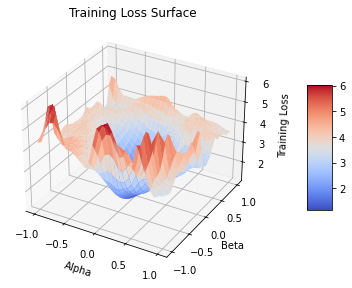

In [26]:
plot_loss_surface(loss_surface, alphas, betas)

## Loss Surface Model Hybrid With ASAM

In [30]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_with_sam = ViTMobileNet(num_classes=len(class_names), in_channels=3, patch_size=8, num_heads=8, embedding_dim=512, num_transformer_layers=12)
model_with_sam = model_with_sam.to(DEVICE)

In [31]:
checkpoint = torch.load("D://Kuliah//UPI//SEMESTER 8//hasil eksperimen//adaptive_sam_v2_best.pt")
model_with_sam.load_state_dict(checkpoint["model_state_dict"])

C:\Users\MoKha\AppData\Local\Temp\ipykernel_7116\4193638197.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("D://Kuliah//UPI//SEMESTER 8//hasil e

<All keys matched successfully>

In [32]:
directions2 = get_random_directions(model_with_sam)

In [33]:
loss_surface2 = compute_loss_surface(model_with_sam, test_loader, directions2, alphas, betas, DEVICE)

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.30it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.29it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:09<00:00,  5.63it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.44it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.45it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.78it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.76it/s]


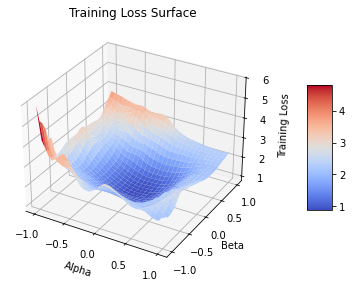

In [34]:
plot_loss_surface(loss_surface2, alphas, betas)

## Loss Surface ViT Without SAM

In [24]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit_without_sam = ViT(num_classes=len(class_names), in_channels=3, patch_size=32, num_heads=8, embedding_dim=512, num_transformer_layers=12)
vit_without_sam = vit_without_sam.to(DEVICE)

In [25]:
checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasil eksperimen//coba_vit_scratch_best.pt")
vit_without_sam.load_state_dict(checkpoint["model_state_dict"])

C:\Users\MoKha\AppData\Local\Temp\ipykernel_12212\3626287623.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasil 

<All keys matched successfully>

In [26]:
directions3 = get_random_directions(vit_without_sam)

In [27]:
loss_surface3 = compute_loss_surface(vit_without_sam, test_loader, directions3, alphas, betas, DEVICE)

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:06<00:00,  8.24it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:06<00:00,  7.61it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:06<00:00,  7.60it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.47it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:06<00:00,  8.21it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:06<00:00,  8.22it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:06<00:00,  8.16it/s]


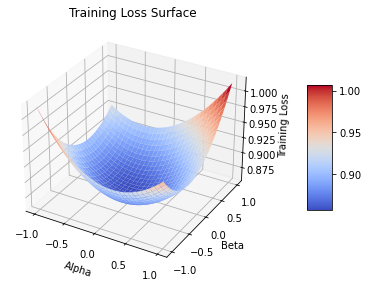

In [28]:
plot_loss_surface(loss_surface3, alphas, betas)

## Loss Surface ViT With SAM

In [29]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(10),     # Randomly rotate by 10 degrees
    transforms.RandomResizedCrop(
        size=IMG_SIZE,  # Output size
        scale=(0.8, 1.0)  # Range of the random crop size relative to the input size
    ),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
]) 

# Create transform pipeline manually
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

 
print(f"train transforms: {train_transforms}")
print(f"test transforms: {test_transforms}")

train transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)
    Normalize(mean=[0.5], std=[0.5])
)
test transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


In [30]:
data = pd.read_csv('E://Kuliah//UPI//SEMESTER 8//dataset skripsi//fer2013_clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33325 entries, 0 to 33324
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pixels   33325 non-null  object
 1   emotion  33325 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 520.8+ KB


In [31]:
# Pertama, pisahkan data train (90%) dan validation (10%)
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=123)
data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=123)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26992
Validation set size: 3000
Test set size: 3333


In [32]:
train_dataset = FERDataset(data_train, transform=train_transforms)
val_dataset = FERDataset(data_val, transform=test_transforms)
test_dataset = FERDataset(data_test, transform=test_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [33]:
EPOCHS = 1000
LEARNING_RATE = 3e-5
NUM_CLASSES = 7
SEED = 123
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))

In [34]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit_with_sam = ViT(num_classes=len(class_names), in_channels=1, patch_size=32, num_heads=8, embedding_dim=256, num_transformer_layers=6)
vit_with_sam = vit_with_sam.to(DEVICE)

In [35]:
checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasil eksperimen//coba_vit_bismillah_best.pt")
vit_with_sam.load_state_dict(checkpoint["model_state_dict"])

C:\Users\MoKha\AppData\Local\Temp\ipykernel_12212\3947293354.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("E://Kuliah//UPI//SEMESTER 8//hasil 

<All keys matched successfully>

In [36]:
directions4 = get_random_directions(vit_with_sam)

In [37]:
loss_surface4 = compute_loss_surface(vit_with_sam, test_loader, directions4, alphas, betas, DEVICE)

Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 21.44it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 21.24it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 21.89it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 21.71it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 21.78it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 21.47it/s]


Testing: 100%|█████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 21.52it/s]


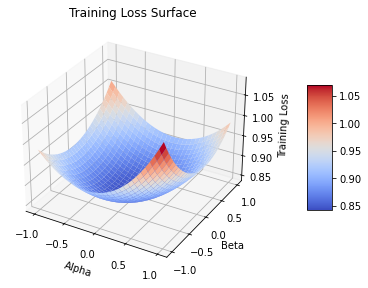

In [38]:
plot_loss_surface(loss_surface4, alphas, betas)

## Plot Loss For Every Configuration

In [35]:
df_scratch = pd.read_csv("D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2//epoch_results.csv")

In [36]:
df_scratch

,Config,Epoch,Train Loss,Train Acc,Val Loss,Val Acc,F1 Score,Learning Rate
0,1,1,1.784058,0.250889,1.792611,0.257667,0.183809,3.000000e-05
1,1,2,1.712717,0.308684,1.695524,0.331333,0.254334,3.000000e-05
2,1,3,1.647681,0.351660,1.642251,0.364333,0.302656,3.000000e-05
3,1,4,1.616570,0.367813,1.609814,0.378333,0.323942,3.000000e-05
4,1,5,1.586310,0.383706,1.612265,0.362333,0.316674,3.000000e-05
...,...,...,...,...,...,...,...,...
395,16,17,0.020475,0.997888,3.082594,0.462667,0.463119,3.000000e-06
396,16,18,0.015755,0.998370,3.222117,0.463667,0.463143,3.000000e-07
397,16,19,0.010856,0.998740,3.233550,0.467333,0.466492,3.000000e-07
398,16,20,0.009709,0.998926,3.252229,0.465333,0.464743,3.000000e-07


C:\Users\MoKha\AppData\Local\Temp\ipykernel_7116\3975900719.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(configs))


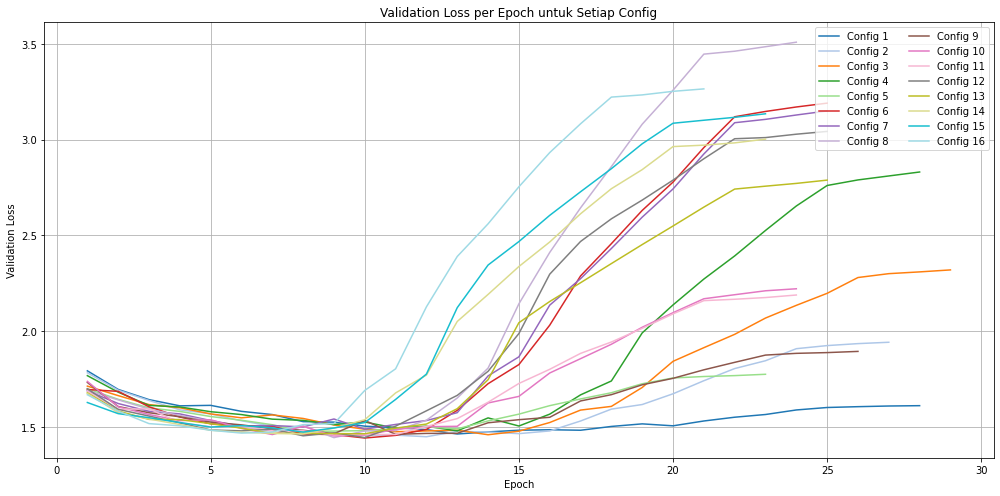

In [38]:
configs = df_scratch["Config"].unique()

colors = plt.cm.get_cmap("tab20", len(configs))

plt.figure(figsize=(14, 7))

# Looping untuk plot tiap config
for i, config_id in enumerate(configs):
    config_data = df_scratch[df_scratch["Config"] == config_id]
    plt.plot(
        config_data["Epoch"],
        config_data["Val Loss"],
        label=f"Config {config_id}",
        color=colors(i)
    )

# Tambahkan label dan elemen grafis lainnya
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Epoch untuk Setiap Config")
plt.legend(loc="upper right", ncol=2)
plt.grid(True)
plt.tight_layout()

# Tampilkan plot
plt.show()

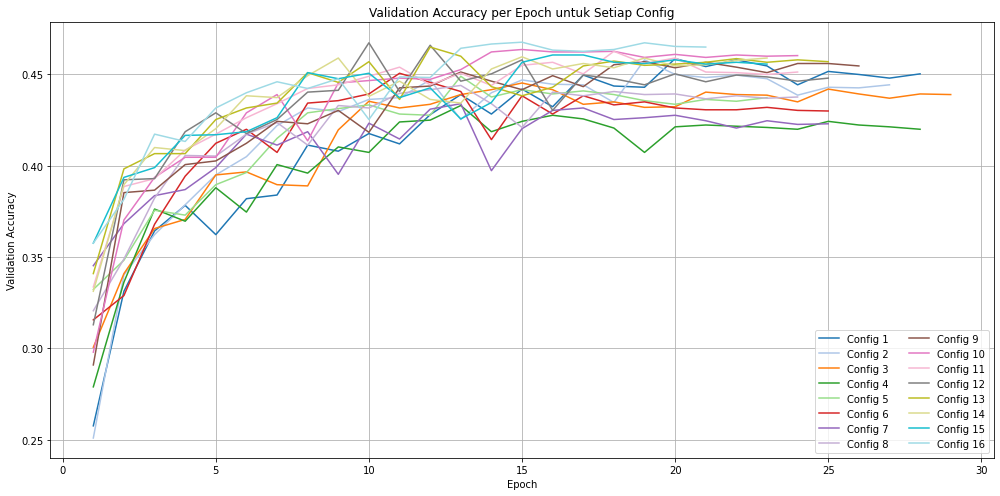

In [39]:
plt.figure(figsize=(14, 7))

# Plot Validation Accuracy per Config
for i, config_id in enumerate(configs):
    config_data = df_scratch[df_scratch["Config"] == config_id]
    plt.plot(
        config_data["Epoch"],
        config_data["Val Acc"],
        label=f"Config {config_id}",
        color=colors(i)
    )

# Tambahkan label dan elemen grafis lainnya
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch untuk Setiap Config")
plt.legend(loc="lower right", ncol=2)
plt.grid(True)
plt.tight_layout()

# Tampilkan plot
plt.show()

In [40]:
df_aug = pd.read_csv("D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2//augment_epoch_results.csv")

In [41]:
df_aug

,Config,Epoch,Train Loss,Train Acc,Val Loss,Val Acc,F1 Score,Learning Rate
0,1,1,1.789996,0.253112,1.797508,0.259667,0.166993,3.000000e-05
1,1,2,1.756634,0.274452,1.711739,0.309667,0.235362,3.000000e-05
2,1,3,1.694358,0.325541,1.680320,0.325000,0.252030,3.000000e-05
3,1,4,1.664747,0.340953,1.638387,0.354000,0.287973,3.000000e-05
4,1,5,1.642039,0.350845,1.625113,0.365333,0.292131,3.000000e-05
...,...,...,...,...,...,...,...,...
1190,16,52,0.917492,0.659306,1.257652,0.535333,0.532393,3.000000e-07
1191,16,53,0.910742,0.660900,1.258613,0.533333,0.530579,3.000000e-08
1192,16,54,0.909192,0.661270,1.258205,0.534000,0.531162,3.000000e-08
1193,16,55,0.911256,0.661122,1.258394,0.533333,0.530405,3.000000e-08


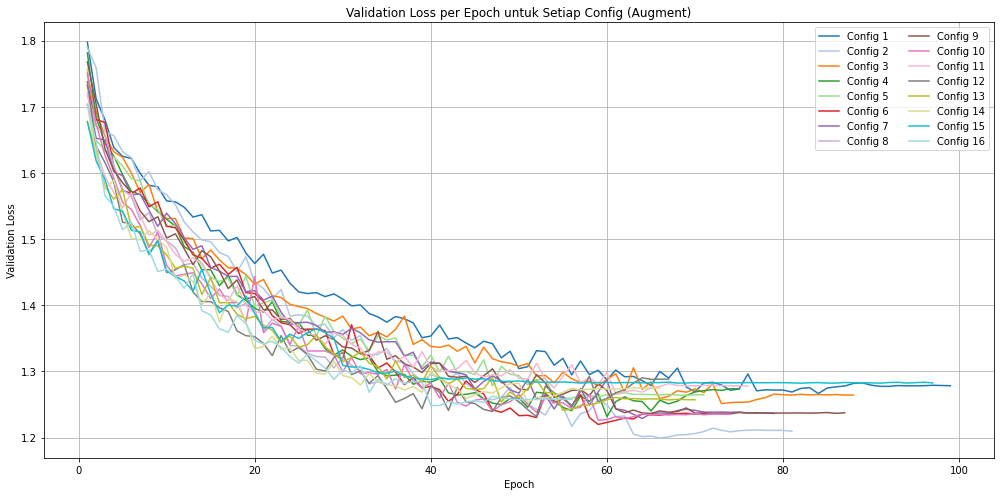

In [42]:
plt.figure(figsize=(14, 7))

# Looping untuk plot tiap config
for i, config_id in enumerate(configs):
    config_data = df_aug[df_aug["Config"] == config_id]
    plt.plot(
        config_data["Epoch"],
        config_data["Val Loss"],
        label=f"Config {config_id}",
        color=colors(i)
    )

# Tambahkan label dan elemen grafis lainnya
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Epoch untuk Setiap Config (Augment)")
plt.legend(loc="upper right", ncol=2)
plt.grid(True)
plt.tight_layout()

# Tampilkan plot
plt.show()

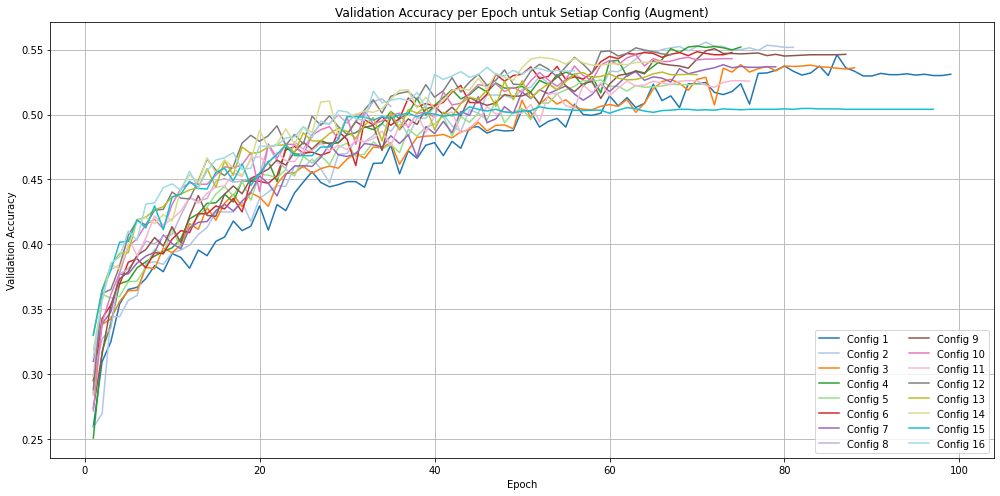

In [43]:
plt.figure(figsize=(14, 7))

# Plot Validation Accuracy per Config
for i, config_id in enumerate(configs):
    config_data = df_aug[df_aug["Config"] == config_id]
    plt.plot(
        config_data["Epoch"],
        config_data["Val Acc"],
        label=f"Config {config_id}",
        color=colors(i)
    )

# Tambahkan label dan elemen grafis lainnya
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch untuk Setiap Config (Augment)")
plt.legend(loc="lower right", ncol=2)
plt.grid(True)
plt.tight_layout()

# Tampilkan plot
plt.show()